<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#FUNCTIONS---Run-at-start" data-toc-modified-id="FUNCTIONS---Run-at-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>FUNCTIONS - Run at start</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Filter-data" data-toc-modified-id="Filter-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Filter data</a></span></li><li><span><a href="#Predicting-based-on-full-info" data-toc-modified-id="Predicting-based-on-full-info-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Predicting based on full info</a></span></li></ul></li><li><span><a href="#Setup-und-Algo" data-toc-modified-id="Setup-und-Algo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup und Algo</a></span></li><li><span><a href="#Algo" data-toc-modified-id="Algo-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Algo</a></span></li><li><span><a href="#Analysis-of-resulting-classifications" data-toc-modified-id="Analysis-of-resulting-classifications-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analysis of resulting classifications</a></span><ul class="toc-item"><li><span><a href="#Error-volatility" data-toc-modified-id="Error-volatility-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Error volatility</a></span></li><li><span><a href="#Distribution-of-classes-per-classification-technique" data-toc-modified-id="Distribution-of-classes-per-classification-technique-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Distribution of classes per classification technique</a></span></li><li><span><a href="#Transition-tables" data-toc-modified-id="Transition-tables-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Transition tables</a></span></li><li><span><a href="#Comparing-mean-return-per-class-for-the-different-classification-techniques" data-toc-modified-id="Comparing-mean-return-per-class-for-the-different-classification-techniques-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Comparing mean return per class for the different classification techniques</a></span></li></ul></li><li><span><a href="#Sanity-checks" data-toc-modified-id="Sanity-checks-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Sanity checks</a></span><ul class="toc-item"><li><span><a href="#Analysing-individual-portfolios" data-toc-modified-id="Analysing-individual-portfolios-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Analysing individual portfolios</a></span></li><li><span><a href="#Inspecting-individual-nearest-neighbors" data-toc-modified-id="Inspecting-individual-nearest-neighbors-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Inspecting individual nearest neighbors</a></span></li></ul></li></ul></div>

# Classification

In [1]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

# Progress bar
from ipywidgets import FloatProgress
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## FUNCTIONS - Run at start

### Load Data

In [2]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

### Filter data 

In [3]:
# Now filter everything
#######################

def filter_data(year):
    year = year
    row_info_f = row_info.copy()
    row_info_f = row_info.query('year == @year')

    begin_date = row_info_f.iloc[0,:]['report_dt']
    end_date = begin_date + pd.DateOffset(years=1,months=1,days = 5)
    row_info_f.reset_index(drop = True, inplace=True)

    # Filter returns
    crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
    returns_f = returns.copy()
    query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
    returns_f = returns_f.query(query)

    # Change return of month for which holdings apply to 0
    returns_f = returns_f.copy()
    mask = returns_f['report_dt'] == begin_date
    returns_f.loc[mask,'mret'] = 0

    # Filter holdings accordingly and delet all empty columns
    holdings_f = holdings.copy()
    holdings_f = holdings[row_info_f['row']]
    col_sums = pd.DataFrame(holdings_f.sum(0).T).values 
    mask = (col_sums != 0).flatten()
    holdings_f = holdings_f[:,mask]
    
    ## Preprocessing
    holdings_ft = normalize(holdings_f)
    
    #print('Numer of unique funds:      {:10,d}'.format(row_info_f.shape[0]))
    #print('Begin date:                 {}'.format(begin_date.date()))
    #print('End date:                   {}'.format(end_date.date()))
    
    return(row_info_f, returns_f, holdings_ft, begin_date, end_date)

In [4]:
def classify(row_info_f, holdings_f, verbose=False):
    
    # Setup
    X = holdings_f
    n_rows = X.shape[0]
    y = list(row_info_f[style_class].values)
    y_df = pd.Series(y)

    style_df = pd.DataFrame({
        'model_lipper' : y})
    style_df['model_knn_iterative'] = style_df['model_lipper']

    # Predict all at once and save in style_df
    neigh_full = KNeighborsClassifier(
                            n_neighbors = n_neighbors,
                            p = distance_param,
                            n_jobs = -1)
    neigh_full.fit(X,y) 
    style_df.loc[:,'model_knn_full'] = neigh_full.predict(X)

    #### Iterative ####

    # Index : Setup of index for choosing rows iteratively
    index = np.arange(n_rows)
    np.random.shuffle(index)
    index = np.concatenate((index,index,index,index,index))
    n_rows_chosen = round(n_rows * perc_rows_used)
    index = index[:n_rows_chosen]
    it = iter(index)
    index = zip(it, it)
    chosen_indices = []

    # Loop over n_iterations, choose one observation randomly, predict label, save and repeat
    f = FloatProgress(min=0, max=n_rows_chosen)
    if(verbose): 
        display(f)

    for i in index:
        mask = np.arange(X.shape[0]) # mask for whole sample
        mask_is = ~np.isin(mask,i)   # mask to choose all in sample observations
        mask_oos = np.isin(mask,i)   # mask to choose the x out of sample observations for which we predict
        chosen_indices.append(i)

        # Mask X and labels to exclude row for which prediction will be made
        X_sub = X[mask_is]
        y_df_sub = style_df.loc[mask_is,'model_knn_iterative'].values.tolist()

        # Fit knn model on all but randomly chosen row
        neigh = KNeighborsClassifier(n_neighbors = n_neighbors, p = distance_param, n_jobs = -1)
        neigh.fit(X_sub,y_df_sub) 

        # Predict and save label for randomly chosen row
        style_df.loc[mask_oos,'model_knn_iterative'] = neigh.predict(X[mask_oos])
        f.value += 2

    row_chosen = np.unique(np.array(chosen_indices).flatten()).shape[0]
    #print('Rows randomly chosen:    {:4.2f}%'.format(row_chosen / X.shape[0] * 100))
    #print('Done')
    
    return(style_df)

In [5]:
def calc_styleadj_returns(row_info,returns_f,style_df):

    row_info_m = row_info_f.copy()
    returns_m = returns_f.copy()

    # concat predicted styles to row_info
    row_info_m = pd.concat([row_info_m,style_df],axis = 1)

    # merge predicted styles onto returns
    returns_m = returns_m.merge(row_info_m[[
                                            'crsp_fundno', 'report_dt', 'model_lipper', 'model_knn_full',
                                            'model_knn_iterative'
                                        ]],
                                       how='left',
                                       on=['crsp_fundno', 'report_dt'])

    # melt the different style columns per model into one (from wide to long)
    returns_m = pd.melt(returns_m,
                               id_vars=['crsp_fundno', 'report_dt', 'mret'],
                               value_vars=cols,
                               var_name='model',
                               value_name='style')

    # Fill all styles and drop nas

    temp = (returns_m
                .groupby(['model','crsp_fundno'])
                .apply(lambda x: x.fillna(method = 'ffill'))
    )

    returns_m['style'] = temp['style']
    returns_m = returns_m.dropna()

    # Calc mean return per style
    style_return = (returns_m
                        .groupby(['model','style','report_dt'])
                        .mean()
                        .reset_index()
                        .drop(columns='crsp_fundno')
    )

    # Calc cumret per style
    style_return['cum_ret'] = (style_return
                                    .assign(cum_ret = lambda x: x.mret + 1)
                                    .groupby(['model','style'])
                                    .apply(lambda x: x['cum_ret'].cumprod())
                                    .reset_index()
                                    ['cum_ret']
    )

    # Merge style returns onto fund returns and calc tracking error
    returns_m = (returns_m
                   .rename(columns = {'mret' : 'fund_ret'}) 
                   .merge(style_return,
                                how ='left',
                                on = ['model','style','report_dt'])
                    .assign(error = lambda df: df['fund_ret'] - df['mret'])
                    .rename(columns = {'mret' : 'style_ret',
                                       'cum_ret' : 'style_cum'}) 
    )

    returns_m = returns_m[['crsp_fundno', 'report_dt', 'model', 'style',
                           'fund_ret', 'style_ret', 'style_cum', 'error']]
    
    return(returns_m)

In [6]:
def error_vola_deciles(returns_m): 
    error_vol = (returns_m
                 .groupby(['crsp_fundno','model'])['error']
                 .std()
                 .reset_index())
    error_vol['error'] = error_vol['error'] * 100
    
    temp = (error_vol
            .groupby('model')[['error']]
            .apply(lambda x : x.quantile(np.round(np.arange(0.1,1,0.1),2)))
            .reset_index()
            .pivot(columns='level_1',values='error',index='model'))
    return(temp)

## Setup und Algo

In [8]:
#### Options #####
##################

year             = 2016

style_class      = 'lipper_class' # Choose lipper_class, style_class or cap_class
n_neighbors      = 5              # Number of neighbors to use in k-nn algorithm
perc_rows_used   = 1              # 1: all funds are reclassified once, 2: ... twice, etc.
distance_param   = 1              # 1: manhattan distance, 2: euclidian distance

cols             = ['model_lipper',
                    'model_knn_full',
                    'model_knn_iterative'] # Do not change, only names

In [9]:
perc_rows_used_l = [1]
distance_param_l = [2]
n_neighbors_l    = [5]

list_df = []

for i in perc_rows_used_l:
    for j in distance_param_l:
        for k in n_neighbors_l:
            print('Start')
            
            np.random.seed(0)

            perc_rows_used = i
            distance_param = j
            n_neighbors    = k

            row_info_f, returns_f, holdings_f, begin_date, end_date = filter_data(year)

            style_df_1 = classify(row_info_f, holdings_f)

            returns_m = calc_styleadj_returns(row_info,returns_f,style_df_1)

            temp = error_vola_deciles(returns_m)

            temp['perc_rows_used'] = perc_rows_used
            temp['distance_param'] = distance_param
            temp['n_neighbors']    = n_neighbors

            list_df.append(temp)

print('Done')
results = pd.concat(list_df)


Start
Done


In [10]:
results.query(''' model == 'model_knn_iterative' ''')
results

level_1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,perc_rows_used,distance_param,n_neighbors
model,,,,,,,,,,,,
model_knn_full,0.507224,0.610966,0.713671,0.809486,0.900970,1.010052,1.154363,1.341526,1.741836,1,2,5
model_knn_iterative,0.519595,0.636672,0.741081,0.822650,0.922371,1.040916,1.206072,1.419449,1.832776,1,2,5
model_lipper,0.501059,0.598620,0.685959,0.780659,0.868994,0.977376,1.109202,1.257533,1.608364,1,2,5


## Analysis of resulting classifications

### Error volatility

In [12]:
error_vol = (returns_m
                 .groupby(['crsp_fundno','model'])['error']
                 .std()
                 .reset_index())

error_vol['error'] = error_vol['error'] * 100
error_vol.groupby('model')['error'].describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
model_knn_full,1901.0,1.171522,1.216637,0.004184,0.704823,0.969611,1.373433,27.513466
model_knn_iterative,1901.0,1.349994,1.246032,0.024761,0.815432,1.158555,1.625610,27.229304
model_lipper,1901.0,1.036918,1.186376,0.070480,0.639031,0.868994,1.180546,27.586490


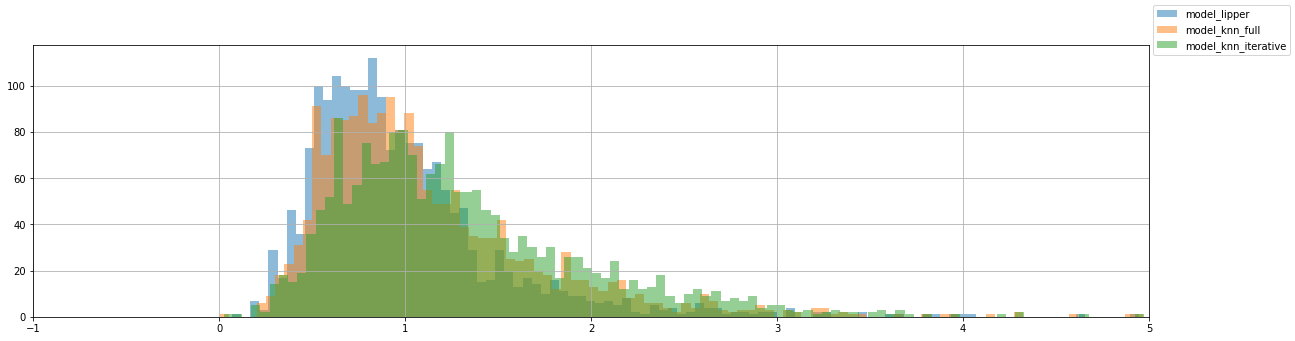

In [13]:
fig, ax = plt.subplots(figsize=(20,5))
for i, col in enumerate(cols):
    ax = error_vol.query(''' model == @col and error < 5''')['error'].hist(label = col,bins = 100, alpha = 0.5)

ax.set_xlim(-1,5)    
fig.legend()
plt.show()

### Distribution of classes per classification technique

In [14]:
print('Overlap between Lipper class and: \n')
print('Knn full prediction:         {:2.2f}%'
      .format(np.sum(style_df['model_lipper'] == style_df['model_knn_full']) / len(style_df.index) * 100))
print('Knn iterative prediction:    {:2.2f}%'
      .format(np.sum(style_df['model_lipper'] == style_df['model_knn_iterative']) / len(style_df.index) * 100))

data = style_df.apply(pd.Series.value_counts, normalize = True)
data = data.assign(style = data.index)
data = data.melt(id_vars = 'style', value_vars = data.columns[:-1])

sns.set()
plt.figure(figsize=(18,10))
g = sns.barplot(data = data, y = 'style', x = 'value', hue = 'variable')

plt.title('Style distribution')
plt.ylabel('Style')
plt.xlabel('Percentage')

plt.show()

Overlap between Lipper class and: 



NameError: name 'style_df' is not defined

### Transition tables

In [ ]:
round(pd.crosstab(style_df['model_lipper'], style_df['model_knn_iterative'], margins=True, normalize='all') * 100,2)

### Comparing mean return per class for the different classification techniques

NameError: name 'style_return' is not defined

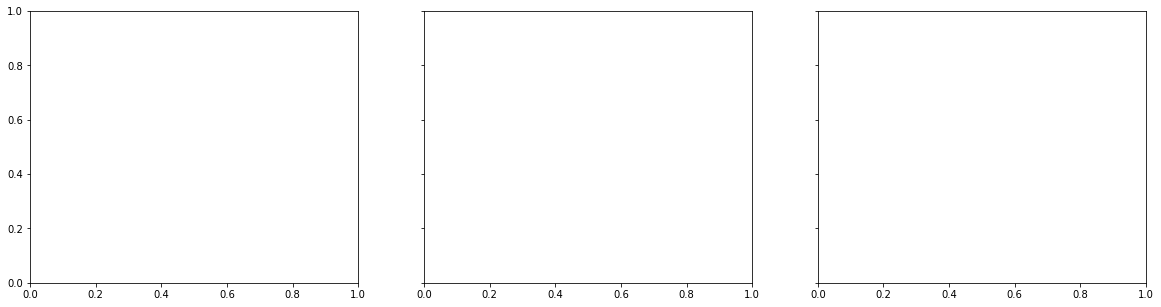

In [15]:
fig, ax = plt.subplots(figsize=(20,5),ncols=3, sharey='row')
for i, col in enumerate(cols):
    sns.lineplot(data = style_return.query(''' model == @col '''),
                 x='report_dt', y='cum_ret', hue='style', ax=ax[i])

# Subplot titles
title = cols
ax[0].set_ylabel('Cumulative return per class')

for i in range(0,3):
    ax[i].set_title(title[i], fontsize = 16)
    ax[i].set_xlabel('')
    for label in ax[i].get_xticklabels():
        label.set_rotation(45)
        
for i in range(1,3):
    ax[i].get_legend().remove()

plt.show()

## Sanity checks

### Analysing individual portfolios

In [ ]:
comparing_df.query('''true == 'V' and iterative_5 == 'G' ''').head()

In [ ]:
crsp_fundno = 18307
most_common_stocks_fund(year=2017, crsp_fundno=crsp_fundno)

In [ ]:
def most_common_stocks_fund(crsp_fundno,row_info,year):
    "This prints a passed string into this function"
    # Enter date for which most common holdings are calculated
    year = year
    crsp_fundno = crsp_fundno
    row_info_l = row_info

    holdings_coo = holdings.tocoo()

    df_sparse = pd.DataFrame({'row'  : holdings_coo.row,
                              'col'  : holdings_coo.col,
                              'data' : holdings_coo.data})

    df_sparse = df_sparse.merge(row_info_l[['year','row','crsp_fundno']],how='left',on='row')
    my_filter = '''year == @year and crsp_fundno == @crsp_fundno '''
    no_unique_funds = row_info_l.query(my_filter).shape[0]

    sum_col = (df_sparse
               .query(my_filter)
               .groupby(by = ['col'])
               .mean()
               .sort_values('data',ascending = False)
               .join(col_info[['security_name','col']],how='left')
               .assign(percent = lambda x:  x.data)
               .drop(columns=['row','data','col','year','crsp_fundno'])
               .reset_index(drop=True)
               .head(10))
    
    print(
        'Average of most held stocks for one fund in one year: ','\n\n'
        '{}'.format(row_info.query('crsp_fundno == @crsp_fundno').iloc[0,2]),'\n\n'
        'crsp_fundno:                            {}'.format(crsp_fundno),'\n'
        'Number of observations in that year:    {}'.format(no_unique_funds))

    return sum_col

### Inspecting individual nearest neighbors

In [ ]:
neigh.kneighbors(X[1234],n_neighbors = n_neighbors)

In [ ]:
def name_nearestneighbors(row_info,neigh,i,n_neighbors = 5):
    print('Name:')
    print(row_info.loc[i].fund_name)
    print(row_info.loc[i].crsp_fundno)
    print('\nNearest Neighbors:')
    nn_index = neigh.kneighbors(X[i],n_neighbors = n_neighbors)[1].flatten()
    nn_names = row_info.loc[nn_index].fund_name.values
    nn_fundno = row_info.loc[nn_index].crsp_fundno.values
    
    for name in nn_names[1:]:
        print(name)

In [ ]:
name_nearestneighbors(row_info,neigh,i = 1234, n_neighbors = 5)

In [ ]:
crsp_fundno = 36608
most_common_stocks_fund(crsp_fundno=crsp_fundno)

In [ ]:
crsp_fundno = 3690
most_common_stocks_fund(crsp_fundno=crsp_fundno)